# Venues Around Hotels in Yekaterinburg, Russia

### Capstone Project
by Eduard Meilakh

## Buisness Problem

Yekaterinburg is the largest city of Ural Federal District, Russia and is the administrative center of Sverdlovsk Region. There are a lot of hotels in Yekaterinburg. Meanwhile, market niches for venues near hotels are overflowing and highly competitive.

In [1]:
yekat_location = (56.83555556, 60.61277778) # latitude and longitude coordinates of Yekaterinburg

In [2]:
import folium
yekat_map = folium.Map(location=yekat_location, zoom_start=11)
label = "Yekaterinburg"
folium.CircleMarker(
        yekat_location,
        radius=5,
        popup=label,
        fill = True,
        fill_opacity=0.7).add_to(yekat_map)
yekat_map

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


The business problem which this project is devoted to is to choose a location for new venue near a hotel in Yekaterinburg. 
We can define the following sub-tasks:
* define a correlation between hotels' features (stars, rating) and types of venues around a hotel 
* compare venues near different hotels in Yekaterinburg (their density and deversity)
* choose hotels with the lowest density of venues near them
* give reccomendations for location and type of new venue.

## Data

We need the following data for our project:
* List of hotels in Yekaterinburg, their coordinates, stars, rating; these data may be scrapped from https://www.gogototour.com/ru/city/yekaterinburg/ and partly from Foursquare; 
* venues around each hotel, their types and ratings; these data may be obtained using Foursquare api.

In [3]:
import requests
from bs4 import BeautifulSoup
from vincenty import vincenty

CENTER_LOCATION = (56.8383, 60.6036)

def capwords(words): # capitalize each word
    return ' '.join(word.capitalize() for word in words.split())

hotels_url = "https://www.gogototour.com/ru/city/yekaterinburg/sort/star/" # hotels of Yekaterinburg sorted by their ratings


hotels_list = set()
pages = ["",
        ]
for page_ind in range(2,6):
    pages.append("/page/"+str(page_ind)) # iterate over 5 pages on this site

for page in pages:
    cur_url = hotels_url+page
    hotels = requests.get(hotels_url)
    html = BeautifulSoup(hotels.text)
    for a_tag in html.find_all("a"): # looking for links to hotels
        try:
            href = a_tag["href"]
            name = a_tag["title"]
            if href.startswith("/ru/hotel") and not href.endswith("review/"):
                hotels_list.add(href)        
        except:
            pass
print("Urls of all hotels are scrapped!")

Urls of all hotels are scrapped!


In [4]:
hotel_url = "https://www.gogototour.com"        

hotel_features = {"names": [],
                   "lats": [],
                   "longs": [],
                   "stars": [],
                   "to_center": [],
                 }

punctuation = '"«»/,()'
COMMON_WORDS = ['hotel', 'hotels', 'отель', 'гостиница', 'екатеринбург', 'ekaterinburg', 'yekaterinburg']
RUS_ABC = ('а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 
           'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 
           'э', 'ю', 'я')
TRANSLIT = ('a', 'b', 'v', 'g', 'd', 'e', 'yo','zh','z', 'i', 'j', 'k', 'l', 'm', 'n',
           'o', 'p', 'r', 's', 't', 'u', 'f', 'h', 'c', 'ch','sh','sch','\'','y', '\'',
           'e', 'yu','ya')
LAT_ABC = tuple("abcdefghijklmnopqrstuvwxyz-")

def clean_name(name): # clean hotel name from punctuation, common words, and translate cyrillic names into latinic
    if "/" in name:
        eng_name = name.split("/")[1].strip()
        rus_name = name.split("/")[0].strip()
        if len(set(eng_name) - set(RUS_ABC)-set(punctuation)) < 3:
            eng_name, rus_name = rus_name, eng_name
        return clean_name(eng_name)
    cleaned_name = ''.join(ch for ch in name.lower() if ch not in punctuation)
    cleaned_name = ' '.join(word for word in cleaned_name.split() if word not in COMMON_WORDS).strip()
    if len(set(cleaned_name) - set(RUS_ABC)) < 3:
        additional_symbols = tuple(set(cleaned_name)-set(RUS_ABC))
        ABC1 = RUS_ABC + additional_symbols
        ABC2 = TRANSLIT + additional_symbols
        cleaned_name = ''.join(ABC2[ABC1.index(ch)] for ch in cleaned_name)        
    return capwords(cleaned_name)

for hotel in hotels_list: #scraping hotels' features: name, latitude, longitude, stars
    name = None
    lat = None
    long = None
    stars = None
    try:
        cur_url = hotel_url+hotel
        results = requests.get(cur_url)
        results = BeautifulSoup(results.text)
        name = results.find("h1", {"class":"hotel"}).text
        name = clean_name(name)
        lat = float(results.find("meta", {"itemprop":"latitude"})["content"])
        long = float(results.find("meta", {"itemprop":"longitude"})["content"])
        stars = results.find("div", {"id":"ofstars"}).find("input", {"class":"val"})["value"]
    except:
        pass
    else:
        if name and lat and long: # if everything is okay append the dictionary with hotels data
            hotel_features["names"].append(name)
            hotel_features["lats"].append(lat)
            hotel_features["longs"].append(long)
            hotel_features["stars"].append(stars)
            hotel_features["to_center"].append(vincenty((lat, long), CENTER_LOCATION))

In [5]:
import pandas as pd
hotels_df = pd.DataFrame(hotel_features)
hotels_name_list = hotels_df['names'].tolist()
hotels_df

,names,lats,longs,stars,to_center
0,Richmond,56.840422,60.656182,4,3.217966
1,Moskovskaya Gorka,56.822496,60.587947,4,2.002584
2,Novotel Centre,56.833200,60.613620,4,0.834631
3,Senator Business,56.841709,60.576708,4,1.684621
4,Vizit,56.890967,60.612001,4,5.887206
5,Viz'avi,56.837612,60.548379,4,3.371344
6,Hyatt Regency,56.843521,60.591788,5,0.926131
7,Ramada,56.775280,60.717830,5,9.896437
8,Palais Royal,56.811040,60.710235,4,7.183738
9,Grand Hall,56.828640,60.559570,4,2.894994


Get more data about hotels in Yekaterinburg using Foursquare

In [6]:
# My credentials
CLIENT_ID = 'QTCDRXKE5AQBE5MSLZS3VR025ZBNOQQQJQMBVZ5TZ0HYUP4B' # your Foursquare ID
CLIENT_SECRET = 'OL0204BY1J0XOJQNKWE5J4NPKC1EJJ4IFYNSABKJOUB5FHBW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
lat, lng = yekat_location
RADIUS = 15000
LIMIT = 100 # A default Foursquare API limit value
query='hotel' # we are looking for hotels

In [7]:
# Foursquare url template
fs_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            query)

In [8]:
results = requests.get(fs_url).json()["response"]['groups'][0]['items']

In [9]:
search_request = "https://tophotels.ru/search?q="

for hotel in results:
    name = clean_name(hotel['venue']['name'])
    if name in hotels_name_list:
        continue
    lat = hotel['venue']['location']['lat']
    long = hotel['venue']['location']['lng']
    query = '+'.join(word for word in name.split())
    query = query.replace('-','+')
    request = requests.get(search_request+query+"+екатеринбург")
    html = BeautifulSoup(request.text)
    try:
        result = html.find('body').find('h2',{'id':'custom-hotel-anchor'})
        stars = int(result.find_next('a').string.split()[-1][0])
        t = result.find_next('a').find_next('span').text.strip()
        if t[:12]!='Екатеринбург':
            raise ValueError('not valid region')
    except:
        pass
    else:          
        hotels_df = hotels_df.append({'names':name, 
                                      'lats': lat, 
                                      'longs':long, 
                                      'stars': stars,
                                      'to_center': vincenty((lat, long), CENTER_LOCATION)}, ignore_index = True)
        print("Hotel <<{}>> is added to dataframe".format(name))

hotels_df = hotels_df.sort_values(by='names', axis = 0, ignore_index=True)
hotels_df['lats'] = hotels_df['lats'].astype(float)
hotels_df['longs'] = hotels_df['longs'].astype(float)

Hotel <<Tenet>> is added to dataframe
Hotel <<Panorama>> is added to dataframe
Hotel <<Park Inn By Radisson>> is added to dataframe
Hotel <<Iset>> is added to dataframe
Hotel <<Marins Park>> is added to dataframe
Hotel <<Moskovskaya Gorka Московская Горка>> is added to dataframe
Hotel <<Live>> is added to dataframe
Hotel <<Pastel>> is added to dataframe
Hotel <<Four Elements>> is added to dataframe
Hotel <<Suite>> is added to dataframe
Hotel <<Senator>> is added to dataframe
Hotel <<Ekaterinburg-tsentralny>> is added to dataframe
Hotel <<Avs>> is added to dataframe


In [10]:
hotels_df

,names,lats,longs,stars,to_center
0,Angelo Airport,56.751256,60.798917,4,15.375251
1,Atlaza City Residence,56.823979,60.637920,4,2.633022
2,Atrium Palace,56.837814,60.596842,5,0.416016
3,Avs,56.904316,60.568357,2,7.659093
4,Best Eastern Uralsky Dvor,56.827579,60.616588,4,1.433141
5,Ekaterinburg-tsentralny,56.834986,60.613076,3,0.686100
6,Four Elements,56.837147,60.586580,4,1.046745
7,Grand Hall,56.828640,60.559570,4,2.894994
8,Hyatt Regency,56.843521,60.591788,5,0.926131
9,Iset,56.840547,60.620724,3,1.074700


In [11]:
with open("hotels_.csv", "w") as f:
    hotels_df.to_csv(f)

In [12]:
with open("hotels_.csv", "r") as f:
    hotels_df = pd.read_csv(f)

yekat_map = folium.Map(location=yekat_location, zoom_start=13)

colors = ['gray', 'lightblue', 'cadetblue', 'darkblue', 'red']

for ind in hotels_df.index:
    loc = (hotels_df['lats'][ind], hotels_df['longs'][ind])
    label = hotels_df['names'][ind]+" "+str(hotels_df['stars'][ind])+"*"
    color = colors[hotels_df['stars'][ind]-1]
    #print(label)
    folium.CircleMarker(
        location=loc,
        radius=5,
        popup=label,
        color=color,
        fill = True,
        fill_opacity=0.7).add_to(yekat_map)



yekat_map

## Venues near hotels (Yekaterinburg, Russia)

Let's define a function to collect venues nearby the hotels.

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    venues_list=[]
    LIMIT = 100
   
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel', 
                  'Hotel Latitude', 
                  'Hotel Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [60]:
venues = getNearbyVenues(names=hotels_df['names'],
                                  latitudes=hotels_df['lats'],
                                  longitudes=hotels_df['longs'])

Angelo Airport
Atlaza City Residence
Atrium Palace
Avs
Best Eastern Uralsky Dvor
Ekaterinburg-tsentralny
Four Elements
Grand Hall
Hyatt Regency
Iset
Live
Marins Park
Moskovskaya Gorka
Moskovskaya Gorka Московская Горка
Novotel Centre
Oktyabrskaya
Onegin
Palais Royal
Panorama
Park Inn
Park Inn By Radisson
Pastel
Ramada
Richmond
Senator
Senator Business
Soldi
Suite
Tenet
Ural
Viz'avi
Vizit
Voznesensky


In [61]:
venues.head(10)

,Hotel,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Angelo Airport,56.751256,60.798917,Зал прибытия,56.750443,60.800361,Airport Service
1,Angelo Airport,56.751256,60.798917,Angelo Airport Hotel 4*,56.750881,60.799312,Hotel
2,Angelo Airport,56.751256,60.798917,Koltsovo International Airport (SVX) (Междунар...,56.750094,60.801070,Airport
3,Angelo Airport,56.751256,60.798917,Ресторан Sunlight,56.750981,60.798772,Eastern European Restaurant
4,Angelo Airport,56.751256,60.798917,Cherry Berry,56.750432,60.802674,Juice Bar
5,Angelo Airport,56.751256,60.798917,Angelo Jazz bar,56.750825,60.799158,Café
6,Angelo Airport,56.751256,60.798917,Паспортный контроль / Passport Control,56.750122,60.803202,Airport Service
7,Angelo Airport,56.751256,60.798917,Charter’s Pub,56.750101,60.802049,Pub
8,Angelo Airport,56.751256,60.798917,Мамуля,56.749940,60.800945,Comfort Food Restaurant
9,Angelo Airport,56.751256,60.798917,Coffeeshop Company,56.750167,60.801731,Coffee Shop


In [62]:
venues.groupby('Hotel').count()

,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Hotel,,,,,,
Angelo Airport,23,23,23,23,23,23
Atlaza City Residence,8,8,8,8,8,8
Atrium Palace,45,45,45,45,45,45
Avs,7,7,7,7,7,7
Best Eastern Uralsky Dvor,12,12,12,12,12,12
Ekaterinburg-tsentralny,40,40,40,40,40,40
Four Elements,15,15,15,15,15,15
Grand Hall,5,5,5,5,5,5
Hyatt Regency,23,23,23,23,23,23


In [63]:
venues_count = venues.groupby('Hotel').count()['Venue'].reset_index()
venues_count.columns = ['Hotel', 'Venues Number']
venues_count

,Hotel,Venues Number
0,Angelo Airport,23
1,Atlaza City Residence,8
2,Atrium Palace,45
3,Avs,7
4,Best Eastern Uralsky Dvor,12
5,Ekaterinburg-tsentralny,40
6,Four Elements,15
7,Grand Hall,5
8,Hyatt Regency,23
9,Iset,27


Let's find out how many unique categories can be curated from all the returned venues

In [64]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 123 uniques categories.


### Hotel Analyzing

In [65]:
import numpy as np
# encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add Hotel column back to dataframe
onehot['Hotel'] = venues['Hotel'] 

# move Hotel column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Yoga Studio,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Theme Park,Tourist Information Center,Toy / Game Store,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Waterfront,Wine Bar,Wine Shop
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next step is to group rows by hotel and calculate the mean of the frequency of occurrence of each category

In [66]:
hotel_grouped = onehot.groupby('Hotel').mean().reset_index()
hotel_grouped

,Hotel,Yoga Studio,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Theme Park,Tourist Information Center,Toy / Game Store,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Waterfront,Wine Bar,Wine Shop
0,Angelo Airport,0.000000,0.0,0.043478,0.086957,0.086957,0.043478,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000
1,Atlaza City Residence,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Atrium Palace,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000
3,Avs,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
4,Best Eastern Uralsky Dvor,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Ekaterinburg-tsentralny,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000
6,Four Elements,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Grand Hall,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Hyatt Regency,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000
9,Iset,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,...,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Function to sort venues in descending order:

In [67]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Dataframe with venues sorted (descending):

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Hotel'] = hotel_grouped['Hotel']

for ind in np.arange(hotel_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(hotel_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angelo Airport,Café,Coffee Shop,Airport Lounge,Airport Service,Pub,Gastropub,Comfort Food Restaurant,Eastern European Restaurant,Russian Restaurant,Boutique
1,Atlaza City Residence,Liquor Store,Café,Soccer Field,Bus Stop,Steakhouse,Shopping Mall,Tennis Stadium,Wine Shop,Electronics Store,Flower Shop
2,Atrium Palace,Coffee Shop,Bookstore,Pizza Place,Fast Food Restaurant,Café,Restaurant,Gym / Fitness Center,Clothing Store,Gastropub,Eastern European Restaurant
3,Avs,Bath House,Playground,Volleyball Court,Karaoke Bar,Park,Gym,Event Space,Food & Drink Shop,Flower Shop,Fast Food Restaurant
4,Best Eastern Uralsky Dvor,Gym / Fitness Center,Restaurant,Café,Park,Street Art,Coffee Shop,Nightclub,Gym,Flower Shop,Convenience Store


In [69]:
venues_sorted = pd.merge(venues_sorted, venues_count, on = 'Hotel')
adding_columns = hotels_df[['names', 'stars', 'to_center']]
adding_columns.columns = ['Hotel', 'Stars', 'Distance to Center']
venues_sorted = pd.merge(venues_sorted, adding_columns, on = 'Hotel')
venues_sorted

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venues Number,Stars,Distance to Center
0,Angelo Airport,Café,Coffee Shop,Airport Lounge,Airport Service,Pub,Gastropub,Comfort Food Restaurant,Eastern European Restaurant,Russian Restaurant,Boutique,23,4,15.375251
1,Atlaza City Residence,Liquor Store,Café,Soccer Field,Bus Stop,Steakhouse,Shopping Mall,Tennis Stadium,Wine Shop,Electronics Store,Flower Shop,8,4,2.633022
2,Atrium Palace,Coffee Shop,Bookstore,Pizza Place,Fast Food Restaurant,Café,Restaurant,Gym / Fitness Center,Clothing Store,Gastropub,Eastern European Restaurant,45,5,0.416016
3,Avs,Bath House,Playground,Volleyball Court,Karaoke Bar,Park,Gym,Event Space,Food & Drink Shop,Flower Shop,Fast Food Restaurant,7,2,7.659093
4,Best Eastern Uralsky Dvor,Gym / Fitness Center,Restaurant,Café,Park,Street Art,Coffee Shop,Nightclub,Gym,Flower Shop,Convenience Store,12,4,1.433141
5,Ekaterinburg-tsentralny,Café,Art Gallery,Coffee Shop,Cocktail Bar,Bakery,Museum,Scenic Lookout,Snack Place,Breakfast Spot,Shopping Mall,40,3,0.686100
6,Four Elements,Restaurant,Gym,Toy / Game Store,French Restaurant,Bar,Mexican Restaurant,Art Gallery,Gym / Fitness Center,Italian Restaurant,Clothing Store,15,4,1.046745
7,Grand Hall,Chinese Restaurant,Pizza Place,Café,Gym / Fitness Center,Bookstore,Wine Shop,Food Truck,Cosmetics Shop,Dance Studio,Deli / Bodega,5,4,2.894994
8,Hyatt Regency,Restaurant,Café,Nightclub,Theater,Russian Restaurant,Mediterranean Restaurant,Fountain,Souvenir Shop,Spa,Waterfront,23,5,0.926131
9,Iset,Bakery,Restaurant,Electronics Store,Caucasian Restaurant,Dance Studio,Beer Garden,Shoe Repair,Coffee Shop,Pedestrian Plaza,Paper / Office Supplies Store,27,3,1.074700


### Descriptive statistics

Let's check if there is a correlation between number of venues and distance to the city center

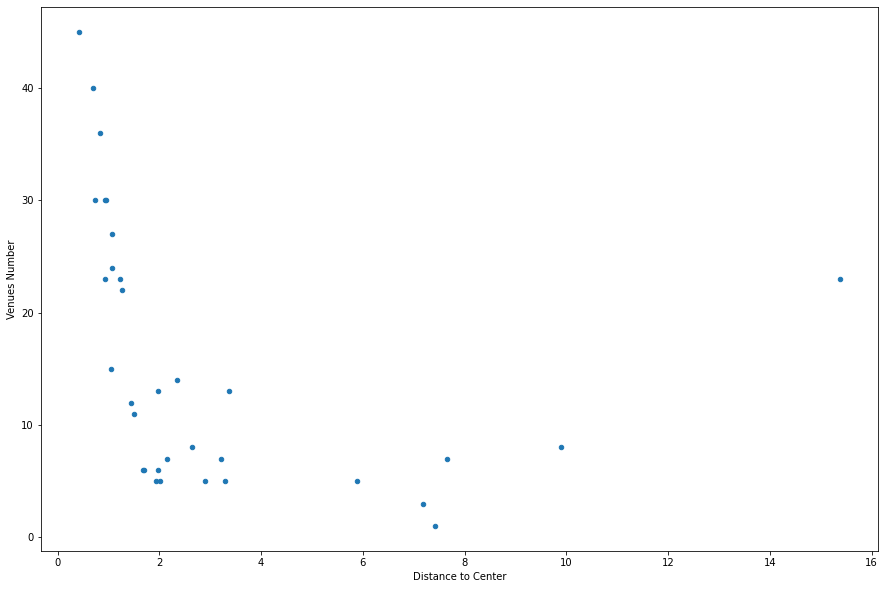

In [70]:
import matplotlib.pyplot as plt

ax1 = venues_sorted.plot.scatter(x='Distance to Center', y = 'Venues Number', figsize=(15,10))

Let's omit the hotel near airport:

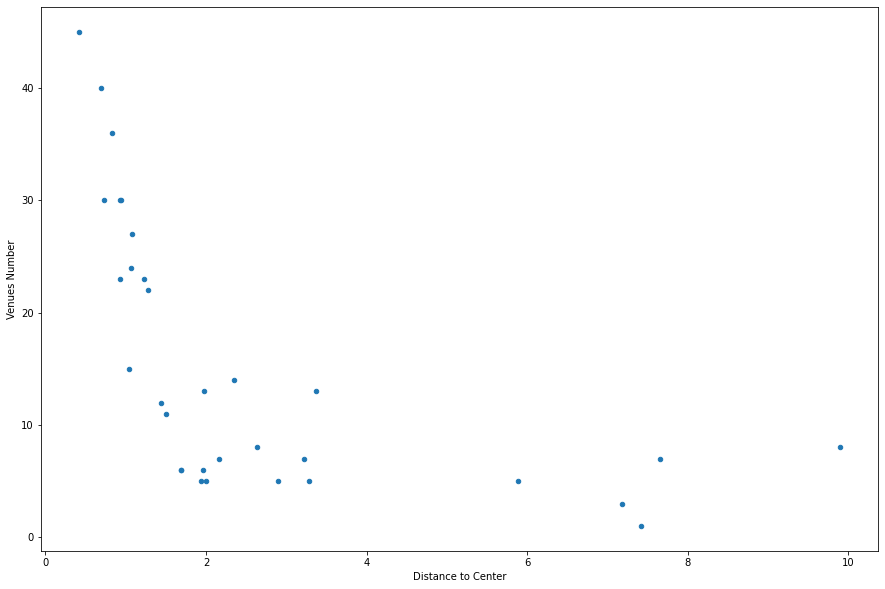

In [71]:
ax1 = venues_sorted.drop(index=0).plot.scatter(x='Distance to Center', y = 'Venues Number', figsize=(15,10))

We can suggest that there are more venues near hotels located in the city center.

Let's check if there is a correlation between hotel's stars and number of venues near it

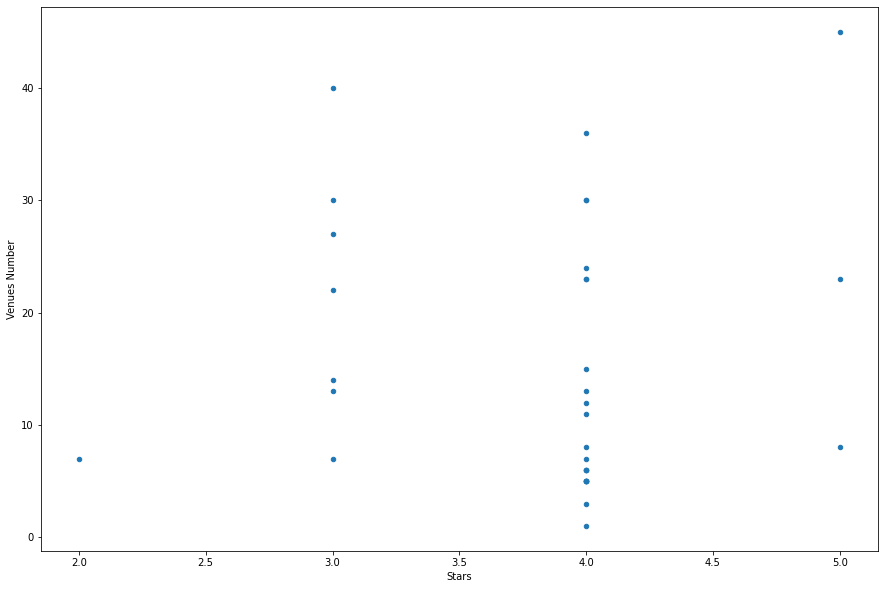

In [72]:
ax1 = venues_sorted.plot.scatter(x='Stars', y = 'Venues Number', figsize=(15,10))

Obviously, there is no correlation between hotel's stars and number of venues near it.

## Clustering of Hotels

We will use K-means method.

In [73]:
from sklearn.cluster import KMeans

We will use data on venues (without information about distance to the city center, hotel's stars and number ofvenues)

In [74]:
hotel_grouped.head()

,Hotel,Yoga Studio,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Theme Park,Tourist Information Center,Toy / Game Store,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Waterfront,Wine Bar,Wine Shop
0,Angelo Airport,0.0,0.0,0.043478,0.086957,0.086957,0.043478,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.043478,0.0
1,Atlaza City Residence,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,Atrium Palace,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.022222,0.0,0.0,0.022222,0.000000,0.0,0.0,0.000000,0.0
3,Avs,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.0,0.0,0.000000,0.0
4,Best Eastern Uralsky Dvor,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [75]:
clustering = hotel_grouped.drop(columns='Hotel')
clustering.head(3)

,Yoga Studio,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Theme Park,Tourist Information Center,Toy / Game Store,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Waterfront,Wine Bar,Wine Shop
0,0.0,0.0,0.043478,0.086957,0.086957,0.043478,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.043478,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.022222,...,0.0,0.022222,0.0,0.0,0.022222,0.0,0.0,0.0,0.000000,0.0


In [77]:
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0], dtype=int32)

In [78]:
# Insert Cluster Labels:
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [79]:
venues_sorted = pd.merge(venues_sorted, hotels_df[['names','lats', 'longs']], left_on = 'Hotel', right_on = 'names')
venues_sorted.head()

,Cluster Labels,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venues Number,Stars,Distance to Center,names,lats,longs
0,0,Angelo Airport,Café,Coffee Shop,Airport Lounge,Airport Service,Pub,Gastropub,Comfort Food Restaurant,Eastern European Restaurant,Russian Restaurant,Boutique,23,4,15.375251,Angelo Airport,56.751256,60.798917
1,1,Atlaza City Residence,Liquor Store,Café,Soccer Field,Bus Stop,Steakhouse,Shopping Mall,Tennis Stadium,Wine Shop,Electronics Store,Flower Shop,8,4,2.633022,Atlaza City Residence,56.823979,60.637920
2,0,Atrium Palace,Coffee Shop,Bookstore,Pizza Place,Fast Food Restaurant,Café,Restaurant,Gym / Fitness Center,Clothing Store,Gastropub,Eastern European Restaurant,45,5,0.416016,Atrium Palace,56.837814,60.596842
3,0,Avs,Bath House,Playground,Volleyball Court,Karaoke Bar,Park,Gym,Event Space,Food & Drink Shop,Flower Shop,Fast Food Restaurant,7,2,7.659093,Avs,56.904316,60.568357
4,0,Best Eastern Uralsky Dvor,Gym / Fitness Center,Restaurant,Café,Park,Street Art,Coffee Shop,Nightclub,Gym,Flower Shop,Convenience Store,12,4,1.433141,Best Eastern Uralsky Dvor,56.827579,60.616588


In [80]:
# Explore Clusters
exploring_clusters = venues_sorted[['Cluster Labels',
                                   'Distance to Center',
                                   'Venues Number',
                                   ]]
exploring_clusters.groupby('Cluster Labels').describe()

Distance to Center                                          \
                            count      mean       std       min       25%   
Cluster Labels                                                              
0                            24.0  2.699894  3.493927  0.416016  0.937295   
1                             8.0  3.307240  2.090543  1.684621  1.874483   
2                             1.0  7.418683       NaN  7.418683  7.418683   

                                              Venues Number             \
                     50%       75%        max         count       mean   
Cluster Labels                                                           
0               1.352994  2.486617  15.375251          24.0  19.541667   
1               2.395474  3.936841   7.183738           8.0   5.625000   
2               7.418683  7.418683   7.418683           1.0   1.000000   

                                                          
                      std  min    25%   50%    75%   max  
Cluster Labels                                            
0               11.617001  5.0  10.25  18.5  27.75  45.0  
1                1.505941  3.0   5.00   5.5   6.25   8.0  
2                     NaN  1.0   1.00   1.0   1.00   1.0

In [81]:
exploring_clusters = venues_sorted[['Hotel',
                                    'Cluster Labels',
                                    '1st Most Common Venue',
                                    '2nd Most Common Venue',
                                    '3rd Most Common Venue',                                    
                                   ]]
coffeeshops = exploring_clusters[(exploring_clusters['1st Most Common Venue']=='Coffee Shop') |
                           (exploring_clusters['2nd Most Common Venue']=='Coffee Shop') |
                           (exploring_clusters['3rd Most Common Venue']=='Coffee Shop')]
coffeeshops

,Hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Angelo Airport,0,Café,Coffee Shop,Airport Lounge
2,Atrium Palace,0,Coffee Shop,Bookstore,Pizza Place
5,Ekaterinburg-tsentralny,0,Café,Art Gallery,Coffee Shop
14,Novotel Centre,0,Cocktail Bar,Café,Coffee Shop
16,Onegin,0,Gym / Fitness Center,Restaurant,Coffee Shop
28,Tenet,0,Coffee Shop,Clothing Store,Gym / Fitness Center


In [82]:
cafes = exploring_clusters[(exploring_clusters['1st Most Common Venue']=='Café') |
                           (exploring_clusters['2nd Most Common Venue']=='Café') |
                           (exploring_clusters['3rd Most Common Venue']=='Café')]
cafes

,Hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Angelo Airport,0,Café,Coffee Shop,Airport Lounge
1,Atlaza City Residence,1,Liquor Store,Café,Soccer Field
4,Best Eastern Uralsky Dvor,0,Gym / Fitness Center,Restaurant,Café
5,Ekaterinburg-tsentralny,0,Café,Art Gallery,Coffee Shop
7,Grand Hall,0,Chinese Restaurant,Pizza Place,Café
8,Hyatt Regency,0,Restaurant,Café,Nightclub
14,Novotel Centre,0,Cocktail Bar,Café,Coffee Shop
19,Park Inn,0,Café,Restaurant,Bakery
20,Park Inn By Radisson,0,Café,Restaurant,Bakery
23,Richmond,0,Café,Hookah Bar,Sushi Restaurant


In [83]:
spa = exploring_clusters[(exploring_clusters['1st Most Common Venue']=='Spa') |
                           (exploring_clusters['2nd Most Common Venue']=='Spa') |
                           (exploring_clusters['3rd Most Common Venue']=='Spa')]
spa

,Hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
30,Viz'avi,0,Playground,Market,Spa


In [84]:
bakery = exploring_clusters[(exploring_clusters['1st Most Common Venue']=='Bakery') |
                           (exploring_clusters['2nd Most Common Venue']=='Bakery') |
                           (exploring_clusters['3rd Most Common Venue']=='Bakery')]
bakery

,Hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
9,Iset,0,Bakery,Restaurant,Electronics Store
19,Park Inn,0,Café,Restaurant,Bakery
20,Park Inn By Radisson,0,Café,Restaurant,Bakery


In [85]:
bars = exploring_clusters[(exploring_clusters['1st Most Common Venue']=='Bar') |
                           (exploring_clusters['2nd Most Common Venue']=='Bar') |
                           (exploring_clusters['3rd Most Common Venue']=='Bar')]
bars

,Hotel,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
22,Ramada,0,Restaurant,Surf Spot,Bar


In [86]:
clustering.insert(0, 'Cluster Labels', kmeans.labels_)

In [87]:
# Explore the most common venues for each cluster:

clusters = clustering.groupby('Cluster Labels').mean() # group all venues categories by cluster labels

columns = clusters.columns 
for col in columns: # transform data into percentage format
    clusters[col] = pd.Series(["{0:.2f}%".format(val * 100) for val in clusters[col]], index = clusters.index)

clusters

,Yoga Studio,ATM,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Theme Park,Tourist Information Center,Toy / Game Store,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Waterfront,Wine Bar,Wine Shop
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.37%,0.00%,0.18%,0.36%,0.36%,0.18%,0.60%,0.60%,1.15%,0.23%,...,0.15%,0.09%,0.28%,0.17%,0.23%,0.60%,0.32%,0.18%,0.18%,0.80%
1,2.50%,2.50%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


Most Common Venues for each cluster, %%:

In [88]:
for ind in clusters.index:
    print("Cluster: {}".format(ind))
    cluster = clusters.iloc[ind].sort_values(ascending=False)
    print(cluster.head(7))
    print("=========================")

Cluster: 0
Gym / Fitness Center           6.76%
Restaurant                     6.74%
Café                           5.96%
Coffee Shop                    5.18%
Karaoke Bar                    2.40%
Eastern European Restaurant    2.24%
Pizza Place                    2.21%
Name: 0, dtype: object
Cluster: 1
Liquor Store    9.79%
Bus Stop        8.35%
Spa             4.17%
Garden          4.17%
Palace          4.17%
Park            4.17%
Yoga Studio     2.50%
Name: 1, dtype: object
Cluster: 2
Bistro               100.00%
Wine Shop              0.00%
French Restaurant      0.00%
Convenience Store      0.00%
Cosmetics Shop         0.00%
Dance Studio           0.00%
Deli / Bodega          0.00%
Name: 2, dtype: object


## Clusters visualization on the map

In [89]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=yekat_location, zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_sorted['lats'], venues_sorted['longs'], venues_sorted['Hotel'], venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    try:
        cluster = int(cluster)
    except:
        print(cluster)
        cluster = 0
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#80ffb4', '#ff0000']
